# GOES Satellite Data

GOES, or Geostationary Operational Environmental Satellite, is a meteorological satellite operated by NOAA. There are two GOES positions, GOES-East, and GOES-West that image weather conditions over the continental U.S. and Eastern Pacific and Northern Atlantic basins. Since April 4, 2025, GOES East has been the GOES-19 satellite, and prior to that, it was the GOES-16 satellite. Similarly, GOES West has been GOES 18 since January 10, 2023, and prior to that it, was the GOES 17 satellite.

There is a lot of information available about these satellites, data, and file structure. When it comes to automated GOES data retrieval, as is the goal of this notebook, one thing that is important to note is that the *scan mode* [has changed](https://cimss.ssec.wisc.edu/satellite-blog/archives/32657), which has changed over the years, and this is likely not the only change over the years. Scan mode 3 was the original default, but in order to obtain more frequent full-disk images, scan mode 6 became the default in April 2019. This change is reflected in the file name, so we need to be sure to consider this for how we retrieve images. 

The data can be obtained from an AWS S3 bucket. To access the data, we can use Amazon S3 or Amazon "Simple Storage Service". Python has a package, [s3fs](https://s3fs.readthedocs.io/en/latest/), which is a file interface to S3 we can use get the data. In order to access the data, we have to know how it is stored. The files are stored in netCDF format in three AWS buckets, `noaa-goes16`, `noaa-goes17`, `noaa-goes18`, and `noaa-goes19`. They are then stored in folders of the format

<center>{Product}/{Year}/{Day of Year}/{Hour}/{Filename}.</center>

The product here will just be `ABI-L1b-RadF`. This is the full-disc radiance from Level-1b (L1b) data generated from Advanced Baseline Imager (ABI). More specifics about L1b products can be found in the [public user's guide](https://www.goes-r.gov/users/docs/PUG-L1b-vol3.pdf). The ABI has 16 bands, but we'll choose band 2. This band has a central wavelength of 0.64 $\mu$m, corresponding to the visible, red band. The filename has a defined structure. Here's an example from [NOAA's GOES on AWS readme](https://github.com/NOAA-Big-Data-Program/nodd-data-docs/blob/main/GOES/README.md):

<center><pre>OR_ABI-L1b-RadF-M3C02_G16_s20171671145342_e20171671156109_c20171671156144.nc</pre></center>

Each segment of the file name and its description are shown below:

<center>

File Name Segment | Description
--- | ---
`OR` | Operational system real-time data
`ABI` | ABI Sensor
`L1b` | processing level
`Rad` | radiances
`F` | full disk
`M3` | mode 3 (scan operation)
`C02` | channel or band 02
`G16` | satellite id for GOES-16
`s20171671145342` | start of scan time
`e20171671156109` | end of scan time
`c20171671156144` | netCDF4 file creation time
`.nc` | netCDF file extension

</center>

With the [AWS client](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-windows.html#cliv2-windows-prereq), we can search for an image via a command like `aws s3 ls s3://noaa-goes16/ABI-L1b-RadF/2018/271/12/ --no-sign-request`. This lists all of the ABI-L1b-RadF products from GOES16 on the 271st day of 2018 at 1200Z. This is a quick way to explore available imagery, rather than iteratively running this code or something similar.

## Import Modules

Let's first import the modules we need to run the code.

In [1]:
import xarray as xr
import requests
import netCDF4
import matplotlib.pyplot as plt
import s3fs
from datetime import datetime, timedelta

## Define Custom Functions

We need to create a few custom functions. We need the following:
* `day_of_year` - a function that takes a date and converts how many days since January 1 of that year have passed
* `read_aws_creds` - a function that reads my AWS credentials downloaded directly from AWS
* `get_s3_keys` - a function that lists all objects in a bucket that start with a prefix string

In [2]:
def day_of_year(date):
    '''
    Take a datetime date and get the number of days since Jan 1 of that same year
    '''
    year = date.year
    firstDay = datetime(year, 1, 1)
    return (date - firstDay).days + 1

def get_satellite_for_date(position, date):
    """
    Get the correct GOES satellite number based on position and date.
    
    Parameters:
    -----------
    position : str
        'goes-east' or 'goes-west'
    date : datetime
        Date to retrieve data for
    
    Returns:
    --------
    str : satellite name (e.g., 'goes16', 'goes19')
    """
    
    if position == 'goes-east':
        # GOES-East transitions
        if date >= datetime(2025, 4, 7):
            return 'goes19'
        else:
            return 'goes16'
    
    elif position == 'goes-west':
        # GOES-West transitions
        if date >= datetime(2023, 1, 10):
            return 'goes18'
        else:
            return 'goes17'
    
    else:
        raise ValueError(f"Position must be 'goes-east' or 'goes-west', got: {position}")

def get_goes_file(position='goes-east', date=None, hour=18, band=2, product='ABI-L1b-RadF'):
    """
    Get a GOES file from AWS S3 (public bucket, no credentials needed)
    
    Parameters:
    -----------
    position : str
        'goes-east' or 'goes-west' (automatically selects correct satellite for date)
        OR specific satellite: 'goes16', 'goes17', 'goes18', 'goes19'
    date : datetime
        Date to retrieve data for
    hour : int
        Hour of day (UTC)
    band : int
        ABI band number
    product : str
        Product name (e.g., 'ABI-L1b-RadF')
    
    Returns:
    --------
    xarray.Dataset
    """
    
    if date is None:
        date = datetime.now() - timedelta(days=30)
    
    # If position is 'goes-east' or 'goes-west', determine the satellite
    if position in ['goes-east', 'goes-west']:
        satellite = get_satellite_for_date(position, date)
        print(f"Using {satellite} for {position} on {date.strftime('%Y-%m-%d')}")
    else:
        # Assume it's a specific satellite name
        satellite = position
    
    # Determine bucket name
    bucket_map = {
        'goes16': 'noaa-goes16',
        'goes17': 'noaa-goes17',
        'goes18': 'noaa-goes18',
        'goes19': 'noaa-goes19'
    }
    
    if satellite not in bucket_map:
        raise ValueError(f"Unknown satellite: {satellite}")
    
    bucket = bucket_map[satellite]
    
    # Determine scan mode based on date
    if date < datetime(2019, 4, 2, 16):
        scan_mode = "M3"
    else:
        scan_mode = "M6"
    
    # Build the S3 path
    year = date.year
    day = day_of_year(date)
    
    prefix = f'{product}/{year}/{day:03.0f}/{hour:02.0f}/'
    pattern = f'OR_{product}-{scan_mode}C{band:02.0f}'
    
    # Initialize s3fs (anonymous access for public buckets)
    fs = s3fs.S3FileSystem(anon=True)
    
    # List files matching the pattern
    s3_path = f'{bucket}/{prefix}'
    try:
        files = fs.ls(s3_path)
        # Filter for the specific band and pattern
        matching_files = [f for f in files if pattern in f]
        
        if not matching_files:
            print(f"No files found matching pattern: {pattern}")
            print(f"Checked path: {s3_path}")
            return None
        
        # Get the first file
        file_path = matching_files[0]
        print(f"Found file: {file_path.split('/')[-1]}")
        
        # Open with xarray
        with fs.open(file_path, 'rb') as f:
            ds = xr.open_dataset(f, engine='h5netcdf')
            # Load into memory to avoid issues when file handle closes
            ds = ds.load()
            
        return ds
        
    except Exception as e:
        print(f"Error accessing S3: {e}")
        return None

### Fetch Images from AWS

Let's now download a NetCDF dataset from the GOES S3 bucket.

In [3]:
# Example usage:
date = datetime.now() - timedelta(days=30)
ds = get_goes_file(position='goes-west', date=date, hour=18, band=2)
rad = ds['Rad']
print(f"Radiance shape: {rad.shape}")
display(ds)

Using goes18 for goes-west on 2025-10-27
Found file: OR_ABI-L1b-RadF-M6C02_G18_s20253001800204_e20253001809513_c20253001809534.nc
Radiance shape: (21696, 21696)


<xarray.Dataset> Size: 4GB
Dimensions:                                           (y: 21696, x: 21696,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       number_of_harmonization_coefficients: 3,
                                                       num_star_looks: 24,
                                                       band: 1)
Coordinates:
  * y                                                 (y) float32 87kB 0.1519...
  * x                                                 (x) float32 87kB -0.151...
    t                                                 datetime64[ns] 8B 2025-...
    y_image                                           float32 4B 0.0
    x_image                                           float32 4B 0.0
    band_id                                           (band) int8 1B 2
    band_wavelength                                   (band) float32 4B 0.64
    t_star_look                                       (num_star_looks) datetime64[ns] 192B ...
    band_wavelength_star_look                         (num_star_looks) float32 96B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_harmonization_coefficients,
                                num_star_looks, band
Data variables: (12/39)
    Rad                                               (y, x) float32 2GB nan ...
    DQF                                               (y, x) float32 2GB nan ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                            int32 4B -2147483647
    y_image_bounds                                    (number_of_image_bounds) float32 8B ...
    x_image_bounds                                    (number_of_image_bounds) float32 8B ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 4B -2147483647
    processing_parm_version_container                 int32 4B -2147483647
    algorithm_product_version_container               int32 4B -2147483647
    star_id                                           (num_star_looks) float32 96B ...
    channel_integration_time                          float64 8B nan
    channel_gain_field                                float64 8B nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2025-10-27T18:09:53.4Z
    time_coverage_start:       2025-10-27T18:00:20.4Z
    time_coverage_end:         2025-10-27T18:09:51.3Z
    LUT_Filenames:             SpaceLookParams(FM3A_CDRL79RevC_DO_13_00_00)-7...
    id:                        719f3c3a-e2ae-4d6a-9fe5-54e42b885d7d

### Plot the Image

Lastly, let's plot our resulting image.

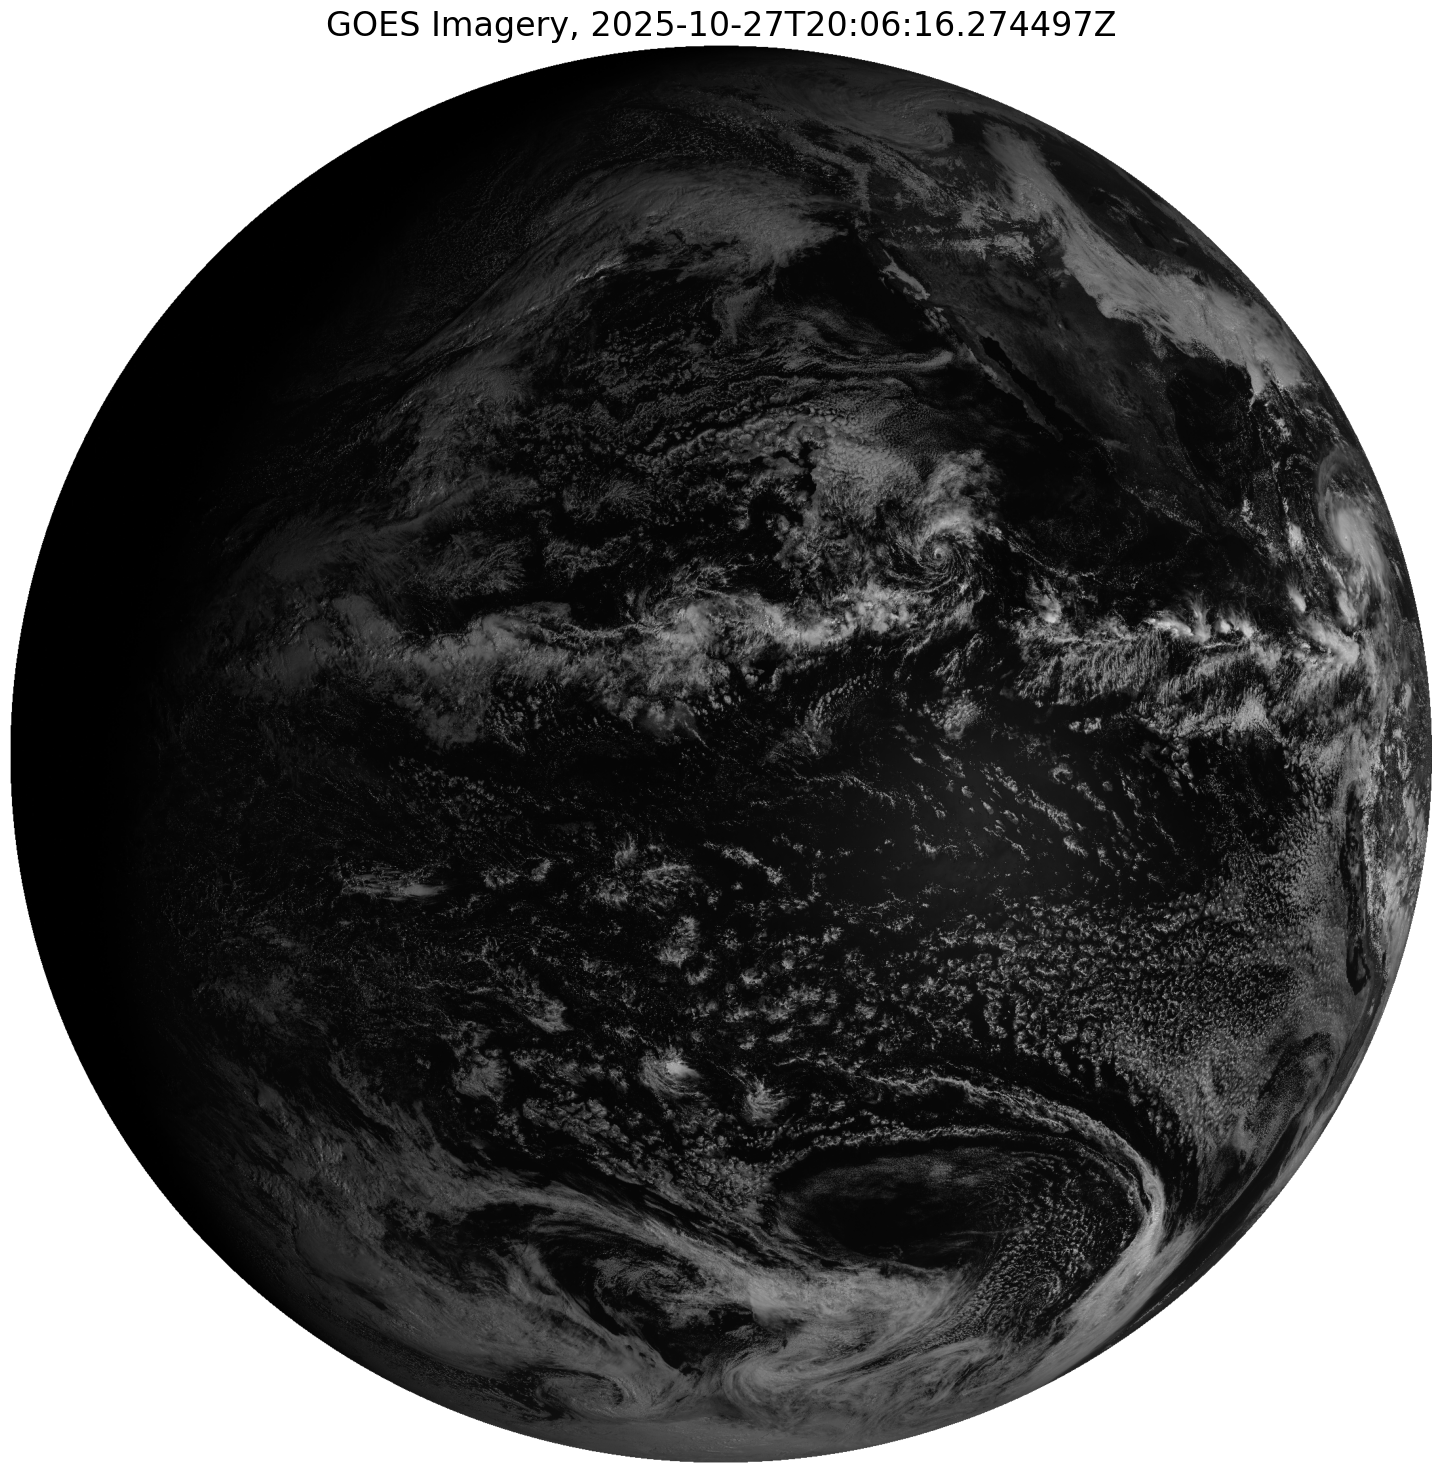

In [4]:
# Downsample by a factor (e.g., every 10th pixel)
downsample_factor = 10
rad_small = rad[::downsample_factor, ::downsample_factor]

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Fill plot data
ax.imshow(rad_small, cmap='gray')

# Add titles
fig.suptitle(f"GOES Imagery, {date.isoformat()}Z", fontsize=24)

# Turn off axes
ax.axis('off')
plt.tight_layout()